In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy.signal import convolve2d
import skimage.measure
from scipy.special import softmax

[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


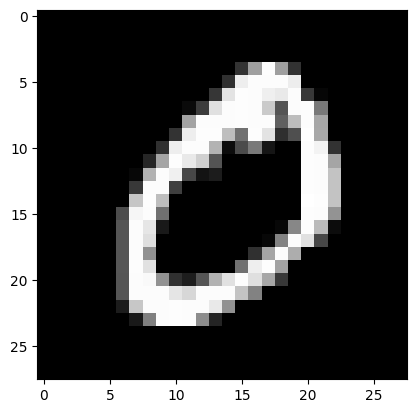

In [2]:
with open('data/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    train_data = data.reshape((size, nrows, ncols))

with open('data/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    print(train_labels)

with open('data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    test_data = data.reshape((size, nrows, ncols))

with open('data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    print(test_labels)

plt.imshow(train_data[1],  cmap='gray')
plt.show()

First, we need to define some helper functions.
The ReLU is used after the convolutions to activate them.
apply_convolution uses convolve2d of scipy to convolve the image and the kernel.
max_pooling uses skimage to pool the image with the pool_size passed as a param.

In [3]:
def relu(x):
    return np.maximum(0, x)

def apply_convolution(image, kernel, bias):
    return convolve2d(image, kernel, mode='valid') + bias

def max_pooling(image, pool_size=(2,2)):
    return skimage.measure.block_reduce(image, pool_size, np.max)

Next, we will build the architecture of our model in OOP.

While working on this, a question arised: what is the difference between adding layers of convolution and adding filters per layer of convolution? How can I choose if I do one or the other? Well, adding layers of convolution typically means increasing the depth of the neural network which allows for learning more complex and abstract features of the image. On the other hand, increasing the number of filters of a convolution layer allows for learning more features at the same level of abstraction. The first has a greater impact on computational complexity.
Adding more layers : Helpful when dealing with more complex patterns or larger input sizes
Adding more filters per layer : Helpful to capture more diverse features at a particular level of abstraction

In [203]:
class ConvLayer:

    def __init__(self, num_filters, kernel_size, stride=1):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.W = None
        self.b = None

    def initialize(self, input_depth):
        self.W = np.random.randn(self.num_filters, self.kernel_size, self.kernel_size, input_depth) / (self.kernel_size * self.kernel_size) # divide xavier initialization
        self.b = np.zeros(self.num_filters)

class CNN:

    def __init__(self, *conv_layers):
        self.conv_layers = conv_layers

    def forward_pass(self, X):
        for i, layer in enumerate(self.conv_layers, 1):
            print(X.shape[-1])
            if layer.W is None:
                layer.initialize(X.shape[-1])
            print(layer.W.shape)
            print(X.shape)
            X = self.convolution(X, layer)
            X = np.maximum(X, 0)  # ReLU
            X = self.max_pool(X)
            print(f"Layer {i} output shape: {X.shape}")
        return X

    # For the convolution, I chose to use scipy.signal.convolve2d as it is implemented and compiled in C
    # which makes it much faster to operate than if I implemented it myself in python (and it's quite easier too...) 
    def convolution(self, X, layer):

        #example :
        #X : (28,28,1)
        #layer.W : (3,3,3,1)
        #output : (26, 26, 3)
        
        print(convolve2d
        
    def max_pool(self, X, pool_size=2):
        n, p = X.shape
        return X[:n//pool_size*pool_size, :p//pool_size*pool_size].reshape(n//pool_size, pool_size, p//pool_size, pool_size).max(axis=(1,3))

cnn = CNN(ConvLayer(3, 3), ConvLayer(1,2))

train_data = train_data.reshape(60000,28,28,1)

cnn.forward_pass(train_data[0])

1
(3, 3, 3, 1)
(28, 28, 1)


TypeError: CNN.convolution() missing 1 required positional argument: 'kernel_size'

## W1 = np.random.randn(5, 5) * 0.01 # 5 by 5 kernels
b1 = np.zeros(1)

# Convolutional layer 2
W2 = np.random.randn(3, 3) * 0.01 # 3 by 3 kernels
b2 = np.zeros(1)

conv1_output_size = train_data.shape[1] - W1.shape[0] + 1
pool1_output_size = conv1_output_size // 2
conv2_output_size = pool1_output_size - W2.shape[0] + 1
pool2_output_size = conv2_output_size // 2
fc_input_size = pool2_output_size * pool2_output_size

W3 = np.random.randn(fc_input_size, 10) * 0.01
b3 = np.zeros(10)

print(W3.shape)

In [5]:
def forward_pass(image):
    
    # First convolutional layer
    conv1 = apply_convolution(image, W1, b1)
    conv1_activated = relu(conv1)
    
    # First pooling layer
    pool1 = max_pooling(conv1_activated)
    
    # Second convolutional layer
    conv2 = apply_convolution(pool1, W2, b2)
    conv2_activated = relu(conv2)
    
    # Second pooling layer
    pool2 = max_pooling(conv2_activated)
    
    # Flatten
    flattened = pool2.flatten()
    
    # Fully connected layer
    fc = np.dot(flattened, W3) + b3
    
    # Output layer with softmax
    output = softmax(fc.reshape(1, -1))
    
    return output

In [47]:
sample_output = forward_pass(train_data[0])
print("Output for first image:", sample_output)
print("Predicted class:", np.argmax(sample_output))
print("Actual class:", train_labels[0])

Output for first image: [[0.10062846 0.10088258 0.10006423 0.09978168 0.09895976 0.10019187
  0.09939027 0.09984605 0.09933434 0.10092076]]
Predicted class: 9
Actual class: 5


In [48]:
all_outputs = np.array([forward_pass(img) for img in train_data[:1000]])

results = np.argmax(all_outputs, axis=-1).T

print("Accuracy over all train dataset:", np.mean(results == train_labels[:1000]))

Accuracy over all train dataset: 0.105


At this point, we achieved the first part of the project. The forward pass allows the model to properly arrive to a conclusion. For now, the result is quite bad due to the randomness of the parameters.

Now we need to implement backpropagation to allow the model to learn by computing the loss and updating the weights and biases accordingly.

My first idea to get the loss was to compute the difference between the actual number and the confidence for each number. For example:
Let's say the actual number is a 2 and the output we got is this [0.09982253 0.10030541 0.1006628  0.09944194 0.09963454 0.10006153
  0.10002742 0.10004489 0.09985413 0.10014481] -> the model predicted a 7

What we would do is first create an array of size 10 for the actual number with zeros for each index not of that number and a one for the right index : [0 0 1 0 0 0 0 0 0 0]

Then we would compute the absolute difference between each value to get the loss for this particular prediction. We would repeat the process for all the 60000 predictions.

After some testing, I noticed that the program was really slow to compute the absolute difference for each of the inputs. I then did some research and found out that my solution, while valid, was really slow and was not really commonly used. After some research, I came accross this the Cross Entropy Loss function which is the default loss function to use for multi-class classification problems.



So that's what we will use for the loss.

In [49]:
def cross_entropy(y_true, y_pred):
    return -np.mean(y_true*np.log(y_pred))

loss = cross_entropy(np.eye(10)[train_labels], all_outputs)

print(loss)

"""
arr = np.zeros(10)
arr[train_labels[0]] = 1
arr = np.eye(10)[train_labels[0]]

loss = abs(np.eye(10)[train_labels] - all_outputs)

print(loss)
"""

0.2302550384901763


'\narr = np.zeros(10)\narr[train_labels[0]] = 1\narr = np.eye(10)[train_labels[0]]\n\nloss = abs(np.eye(10)[train_labels] - all_outputs)\n\nprint(loss)\n'

In [ ]:
l